In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn import metrics
## hyper parameters for tuning and model variations
from sklearn.model_selection import GridSearchCV, train_test_split
set_config(display='diagram')

data=pd.read_csv('total_celltower.csv')

data.time=pd.to_datetime(data.time)
data.set_index(data['time'],inplace=True)

# Get indexes where name column has value john
data=data[data.index.month !=6]
data=data[data.index.month !=7]


In [2]:
minute=pd.read_csv('resample_60s_celltower2.csv')
minute.head()

,time,cfm,COP,Delta_Enthalpy,kw,kwton,OAtemp,humidity1,temp1,eer,compressor_on,Day_of_week,month,Hour_of_day
0,2021-06-23 15:28:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,6,15
1,2021-06-23 15:43:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,6,15
2,2021-06-23 15:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,6,15
3,2021-06-23 15:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,6,15
4,2021-06-23 15:46:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,6,15


In [3]:
columns=minute.columns
columns

Index(['time', 'cfm', 'COP', 'Delta_Enthalpy', 'kw', 'kwton', 'OAtemp',
       'humidity1', 'temp1', 'eer', 'compressor_on', 'Day_of_week', 'month',
       'Hour_of_day'],
      dtype='object')

In [4]:
minute=pd.read_csv('resample_60s_celltower2.csv')
minute.time=pd.to_datetime(minute.time)
minute.set_index(minute['time'],inplace=True)
minute=minute[minute.kwton>=0]
minute=minute[minute.kwton <1300]
minute=minute[minute.eer<1]
minute.dropna(inplace=True)
minute.drop('time',axis=1,inplace=True)
minute.index.name = None


In [5]:
minute_clean=pd.read_csv('Full_Cell_1s_cleaned_data.csv')
minute_clean.head(5)

,time,name,cfm,COP,Delta_Enthalpy,dewpoint1,dewpoint2,eer,kw,kwton,...,humidity2,temp2,enthalpy2,hour,day_of_week,day,month,week,year,comp_num
0,2021-06-26 21:56:17,458,19.32,0.02,0.73,53.17,51.69,0.06,1.98,198.0,...,53.9,73.1,27.78,21,5,26,6,25,2021,1
1,2021-06-26 21:56:19,458,19.32,0.02,0.73,53.17,51.69,0.06,1.98,198.0,...,53.9,73.1,27.78,21,5,26,6,25,2021,1
2,2021-06-26 21:56:24,458,20.01,0.02,0.73,53.17,51.69,0.06,1.99,199.0,...,53.9,73.1,27.78,21,5,26,6,25,2021,1
3,2021-06-26 21:56:28,458,19.32,0.02,0.71,53.17,51.75,0.05,1.98,198.0,...,54.0,73.1,27.80,21,5,26,6,25,2021,1
4,2021-06-26 21:57:10,458,18.63,0.02,0.79,53.17,51.60,0.06,1.98,198.0,...,53.9,73.0,27.72,21,5,26,6,25,2021,1


In [6]:
minute_clean.columns

Index(['time', 'name', 'cfm', 'COP', 'Delta_Enthalpy', 'dewpoint1',
       'dewpoint2', 'eer', 'kw', 'kwton', 'OAtemp', 'humidity1', 'temp1',
       'enthalpy1', 'humidity2', 'temp2', 'enthalpy2', 'hour', 'day_of_week',
       'day', 'month', 'week', 'year', 'comp_num'],
      dtype='object')

In [7]:
dict = {
    'day_of_week':'Day_of_week',
    'hour':'Hour_of_day'
}

In [8]:
minute=minute_clean[['time',
                     'name',
                     'cfm', 
                     'COP', 
                     'Delta_Enthalpy',
                     'kw', 
                     'kwton', 
                     'OAtemp',
                     'humidity1', 
                     'temp1',
                     'eer',
                     'hour',
                     'day',
                     'day_of_week',
                     'month',
                     'year']].copy()

In [9]:
minute.rename(columns=dict,
          inplace=True)

In [10]:
minute.time=minute.time.astype('datetime64')

In [11]:
minute['kwton'].astype(float)

0          198.00
1          198.00
2          199.00
3          198.00
4          198.00
            ...  
3782743      0.81
3782744      0.80
3782745      0.80
3782746      0.81
3782747      0.80
Name: kwton, Length: 3782748, dtype: float64

In [12]:
minute.head()

,time,name,cfm,COP,Delta_Enthalpy,kw,kwton,OAtemp,humidity1,temp1,eer,Hour_of_day,day,Day_of_week,month,year
0,2021-06-26 21:56:17,458,19.32,0.02,0.73,1.98,198.0,74.12,55.2,73.9,0.06,21,26,5,6,2021
1,2021-06-26 21:56:19,458,19.32,0.02,0.73,1.98,198.0,74.12,55.2,73.9,0.06,21,26,5,6,2021
2,2021-06-26 21:56:24,458,20.01,0.02,0.73,1.99,199.0,74.12,55.2,73.9,0.06,21,26,5,6,2021
3,2021-06-26 21:56:28,458,19.32,0.02,0.71,1.98,198.0,73.94,55.2,73.9,0.05,21,26,5,6,2021
4,2021-06-26 21:57:10,458,18.63,0.02,0.79,1.98,198.0,73.94,55.2,73.9,0.06,21,26,5,6,2021


In [13]:
minute.shape

(3782748, 16)

minute['kwton_shift'] =minute.kwton.shift(1).copy()

def turnedon(minute):
    if ((minute['kwton']!=0.0) & (minute['kwton_shift'] ==0.0)):
        return 1 
    else:
        return 0
        

minute['turnedon']=minute.apply(turnedon,axis=1)

minute.drop('kwton_shift',axis=1,inplace=True)

In [14]:
minute=minute.set_index('time')


In [15]:
features=list(minute.columns)
features

['name',
 'cfm',
 'COP',
 'Delta_Enthalpy',
 'kw',
 'kwton',
 'OAtemp',
 'humidity1',
 'temp1',
 'eer',
 'Hour_of_day',
 'day',
 'Day_of_week',
 'month',
 'year']

In [16]:
minute=minute[features].resample('60S').median().dropna()
minute.head()

,name,cfm,COP,Delta_Enthalpy,kw,kwton,OAtemp,humidity1,temp1,eer,Hour_of_day,day,Day_of_week,month,year
time,,,,,,,,,,,,,,,
2021-06-26 21:56:00,458.0,19.320,0.02,0.73,1.98,198.00,74.12,55.20,73.9,0.060,21.0,26.0,5.0,6.0,2021.0
2021-06-26 21:57:00,458.0,18.975,0.02,0.75,1.98,198.00,73.94,59.20,73.8,0.050,21.0,26.0,5.0,6.0,2021.0
2021-06-26 21:58:00,458.0,19.320,0.02,0.75,1.98,198.00,73.94,59.20,73.8,0.060,21.0,26.0,5.0,6.0,2021.0
2021-06-26 21:59:00,458.0,19.320,0.02,0.73,1.98,198.00,73.94,59.10,73.8,0.060,21.0,26.0,5.0,6.0,2021.0
2021-06-26 22:00:00,458.0,18.975,0.09,7.28,1.98,41.25,73.94,89.55,74.4,0.555,22.0,26.0,5.0,6.0,2021.0


In [17]:
minute.dtypes

name              float64
cfm               float64
COP               float64
Delta_Enthalpy    float64
kw                float64
kwton             float64
OAtemp            float64
humidity1         float64
temp1             float64
eer               float64
Hour_of_day       float64
day               float64
Day_of_week       float64
month             float64
year              float64
dtype: object

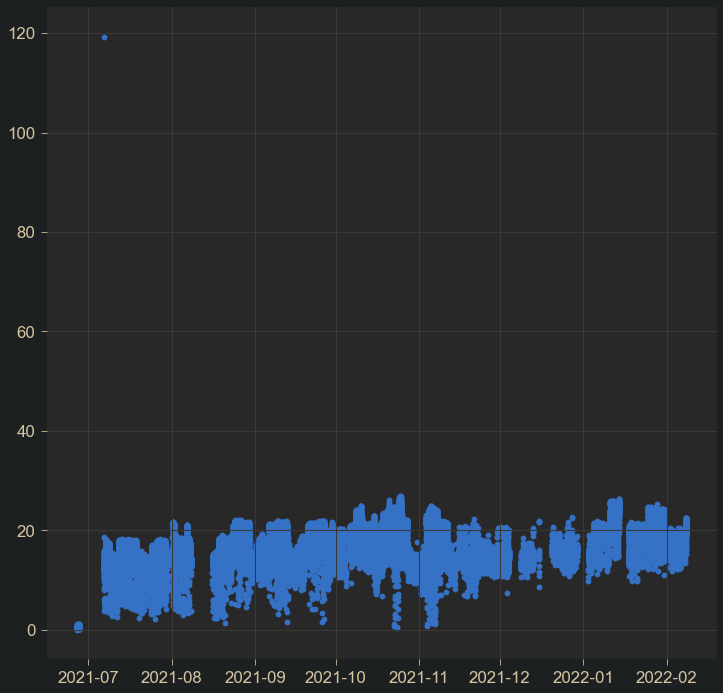

In [18]:
plt.scatter(minute.index,minute.eer)

<AxesSubplot:xlabel='time'>

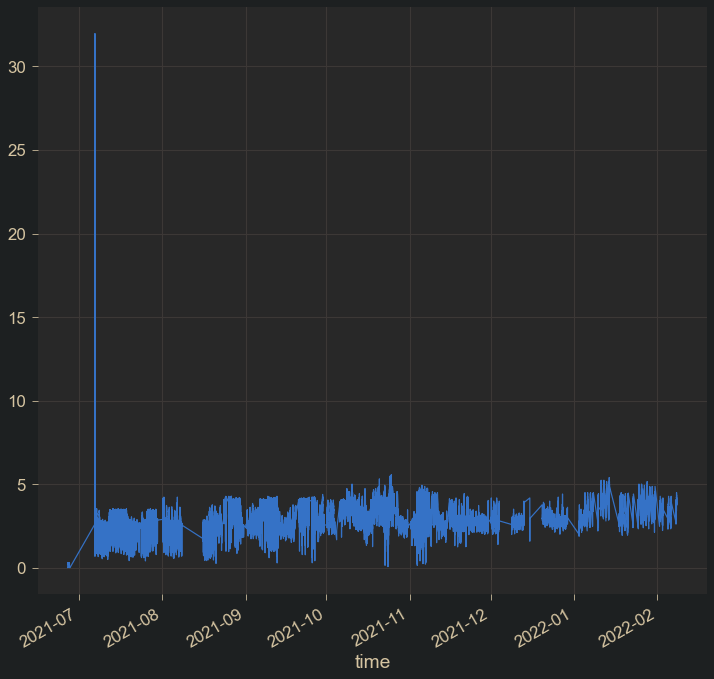

In [19]:
minute.COP.plot()

In [20]:
split_date='2021-07-13 11:00:08'
start_date='2021-07-6 11:00:08'
training_start='2021-8-3 11:00:08'
#training with pre treatment data
x=minute.drop(['COP','eer','kwton'],axis=1)
y_cop_total=minute['COP']
y_eer_total=minute['eer']
y_kwton_total=minute['kwton']
x_train=minute[training_start:].drop(['COP','eer','kwton'],axis=1)
xtest=minute[start_date:split_date].drop(['COP','eer','kwton'],axis=1)

y_train=minute[training_start:][['COP','eer','kwton']]
y_test= minute[start_date:split_date][['COP','eer','kwton']]


In [21]:
minute.shape

(124582, 15)

In [22]:
minute.index.min()

Timestamp('2021-06-26 21:56:00')

In [23]:
xtrain, xval, y_train, y_val=train_test_split(x_train,y_train)


In [24]:
COP_test=y_test['COP']
eer_test=y_test['eer']
kwton_test=y_test['kwton']

COP_train=y_train['COP']
eer_train=y_train['eer']
kwton_train=y_train['kwton']

COP_val=y_val['COP']
eer_val=y_val['eer']
kwton_val=y_val['kwton']

In [25]:
cat_features=['Day_of_week','month','Hour_of_day','name']
num_features=['cfm','Delta_Enthalpy','OAtemp','humidity1','temp1','kw']
processor=ColumnTransformer(transformers=[
    ('cat_processor',OneHotEncoder(handle_unknown='ignore'),cat_features),
    ('num_processor',MinMaxScaler(),num_features),
])
forest_cop =Pipeline(steps=[
    ('preprocessor',processor),
    ('reg',RandomForestRegressor(max_depth= 5,
                                  min_samples_leaf= 4,
                                  min_samples_split= 4,
                                  n_estimators=100))
])

In [26]:
## train /pred COP
forest_cop.fit(xtrain,COP_train)

COP_train_pred=forest_cop.predict(xtrain)
COP_val_pred=forest_cop.predict(xval)
COP_test_pred=forest_cop.predict(xtest)


COP_train_residuals=COP_train-COP_train_pred
COP_val_residuals=COP_val-COP_val_pred
COP_test_residuals=COP_test-COP_test_pred


In [27]:
cat_features=['Day_of_week','month','Hour_of_day','name']
num_features=['cfm','Delta_Enthalpy','OAtemp','humidity1','temp1','kw']
processor=ColumnTransformer(transformers=[
    ('cat_processor',OneHotEncoder(handle_unknown='ignore'),cat_features),
    ('num_processor',MinMaxScaler(),num_features),
])
forest_kwton =Pipeline(steps=[
    ('preprocessor',processor),
    ('reg',RandomForestRegressor(max_depth= 5,
                                  min_samples_leaf= 4,
                                  min_samples_split= 4,
                                  n_estimators=100))
])

In [28]:
## train /pred kwton
forest_kwton.fit(xtrain,kwton_train)

kwton_train_pred=forest_kwton.predict(xtrain)
kwton_val_pred=forest_kwton.predict(xval)
kwton_test_pred=forest_kwton.predict(xtest)

kwton_train_residuals=kwton_train-kwton_train_pred
kwton_val_residuals=kwton_val-kwton_val_pred
kwton_test_residuals=kwton_test-kwton_test_pred

In [29]:
cat_features=['Day_of_week','month','Hour_of_day','name']
num_features=['cfm','Delta_Enthalpy','OAtemp','humidity1','temp1','kw']
processor=ColumnTransformer(transformers=[
    ('cat_processor',OneHotEncoder(handle_unknown='ignore'),cat_features),
    ('num_processor',MinMaxScaler(),num_features),
])
forest_eer =Pipeline(steps=[
    ('preprocessor',processor),
    ('reg',RandomForestRegressor(max_depth= 5,
                                  min_samples_leaf= 4,
                                  min_samples_split= 4,
                                  n_estimators=100))
])

In [30]:
## train /pred eer
forest_eer.fit(xtrain,eer_train)


eer_train_pred=forest_eer.predict(xtrain)
eer_val_pred=forest_eer.predict(xval)
eer_test_pred=forest_eer.predict(xtest)

eer_train_residuals=eer_train-eer_train_pred
eer_val_residuals=eer_val-eer_val_pred
eer_test_residuals=eer_test-eer_test_pred


In [31]:
#totals
COP_total_pred=forest_cop.predict(x)
kwton_total_pred=forest_kwton.predict(x)
eer_total_pred=forest_eer.predict(x)

#totals

COP_total_res =y_cop_total-COP_total_pred
kwton_total_res =y_kwton_total-kwton_total_pred
eer_total_res =y_eer_total-eer_total_pred

minute['COP_total_res'] = COP_total_res
minute['kwton_total_res'] = kwton_total_res
minute['eer_total_res'] = eer_total_res


minute['COP_norm_total_res']=(COP_total_res-np.quantile(COP_total_res,.05))/(np.quantile(COP_total_res,.95)-np.quantile(COP_total_res,.05))
minute['kwton_norm_total_res']=(kwton_total_res-np.quantile(kwton_total_res,.05))/(np.quantile(kwton_total_res,.95)-np.quantile(kwton_total_res,.05))
minute['eer_norm_total_res']=(eer_total_res-np.quantile(eer_total_res,.05))/(np.quantile(eer_total_res,.95)-np.quantile(eer_total_res,.05))

In [32]:
minute.shape

(124582, 21)

In [33]:
minute[['COP_norm_total_res','kwton_norm_total_res','eer_norm_total_res']].isna().sum()

COP_norm_total_res      0
kwton_norm_total_res    0
eer_norm_total_res      0
dtype: int64

0.014695154665267477


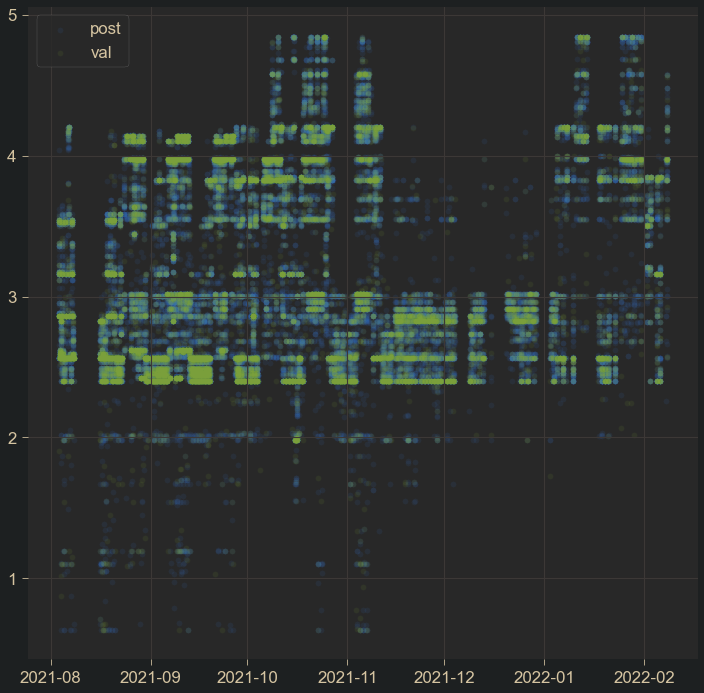

In [34]:
print(mean_squared_error(COP_val,COP_val_pred))
plt.scatter(xtrain.index,COP_train_pred,label='post',alpha=.1)
plt.scatter(xval.index,COP_val_pred,label='val',alpha=.1)
#plt.scatter(xtest.index,COP_test_pred,label='pre',alpha=.1)
plt.legend()

0.2977644559859065


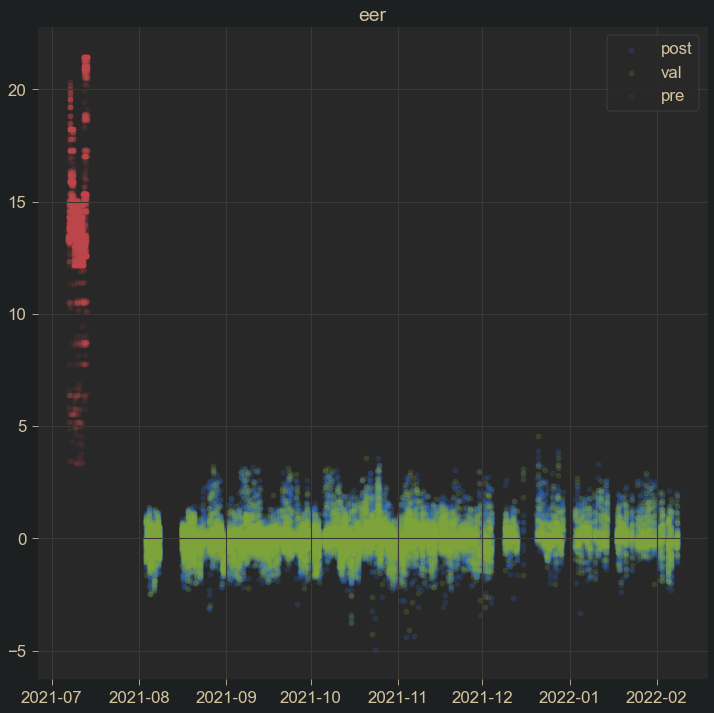

In [35]:
print(mean_squared_error(eer_val,eer_val_pred))
plt.scatter(xtrain.index,eer_train_residuals,label='post',alpha=.2)
plt.scatter(xval.index,eer_val_residuals,label='val',alpha=.2)
plt.scatter(xtest.index,eer_test_pred,label='pre',alpha=.1)
plt.title('eer')
plt.legend()

0.009529206654212736


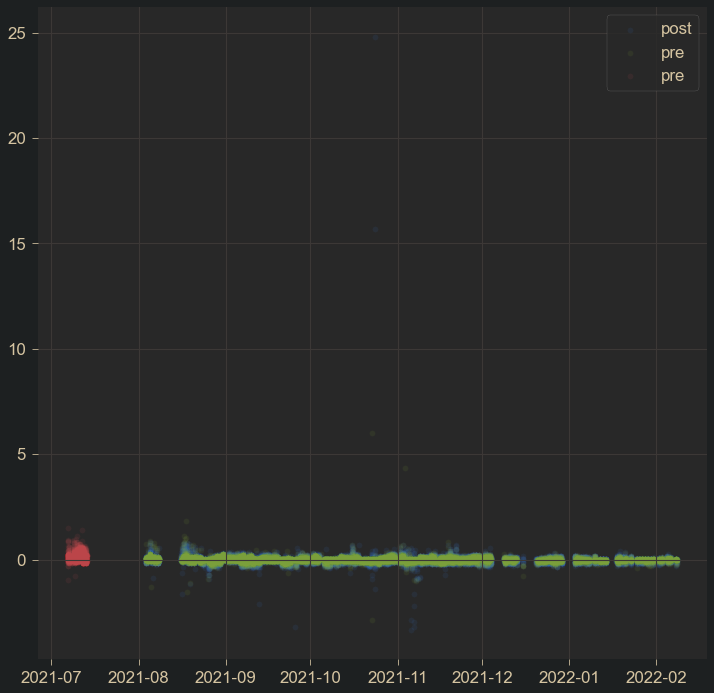

In [36]:
print(mean_squared_error(kwton_val,kwton_val_pred))
plt.scatter(xtrain.index,kwton_train_residuals,label='post',alpha=.1)
plt.scatter(xval.index,kwton_val_residuals,label='pre',alpha=.1)
plt.scatter(xtest.index,kwton_test_residuals,label='pre',alpha=.1)
plt.legend()

In [37]:

cop_val_r2=(np.std(COP_val)**2-np.mean(COP_val_residuals**2))/np.std(COP_val)**2
cop_test_r2=(np.std(COP_test)**2-np.mean(COP_test_residuals**2))/np.std(COP_test)**2

cop_train_r2=(np.std(COP_train)**2-np.mean(COP_train_residuals**2))/np.std(COP_train)**2

eer_val_r2=(np.std(eer_val)**2-np.mean(eer_val_residuals**2))/np.std(eer_val)**2
eer_test_r2=(np.std(eer_test)**2-np.mean(eer_test_residuals**2))/np.std(eer_test)**2
eer_train_r2=(np.std(eer_train)**2-np.mean(eer_train_residuals**2))/np.std(eer_train)**2


kwton_val_r2=(np.std(kwton_val)**2-np.mean(kwton_val_residuals**2))/np.std(kwton_val)**2
kwton_test_r2=(np.std(kwton_test)**2-np.mean(kwton_test_residuals**2))/np.std(kwton_test)**2
kwton_train_r2=(np.std(kwton_train)**2-np.mean(kwton_train_residuals**2))/np.std(kwton_train)**2


cop=np.hstack((cop_val_r2,cop_train_r2,cop_test_r2))
eer=np.hstack((eer_val_r2,eer_train_r2,eer_test_r2))
kwton=np.hstack((kwton_val_r2,kwton_train_r2,kwton_test_r2))

rdata=np.vstack((cop,eer,kwton))




RS=pd.DataFrame(columns=[['r2_val','r2_train','r2_test']], index=['cop','eer','kwton'],data=rdata)

RS

,r2_val,r2_train,r2_test
cop,0.970940,0.971678,0.340117
eer,0.973799,0.974569,0.481237
kwton,0.934615,0.865131,0.779917


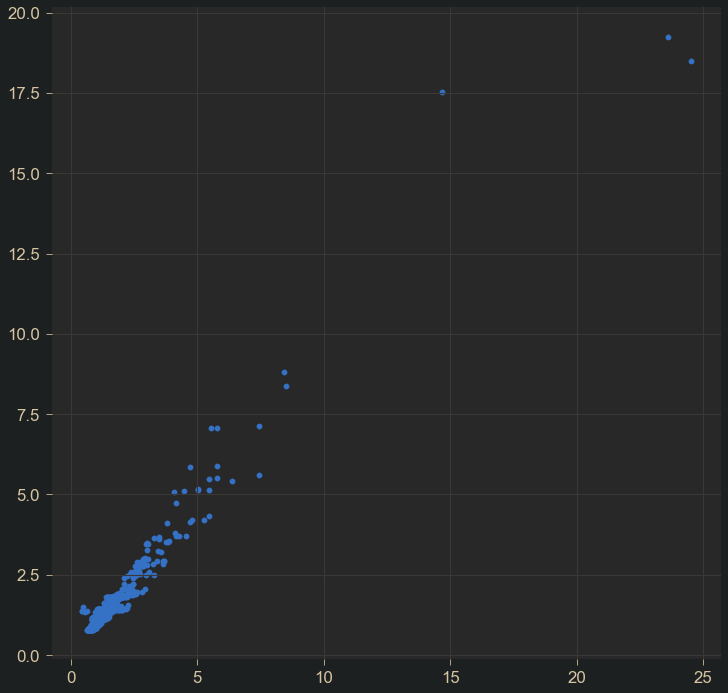

In [38]:
plt.scatter(kwton_val,kwton_val_pred)

(0.0, 20.0)

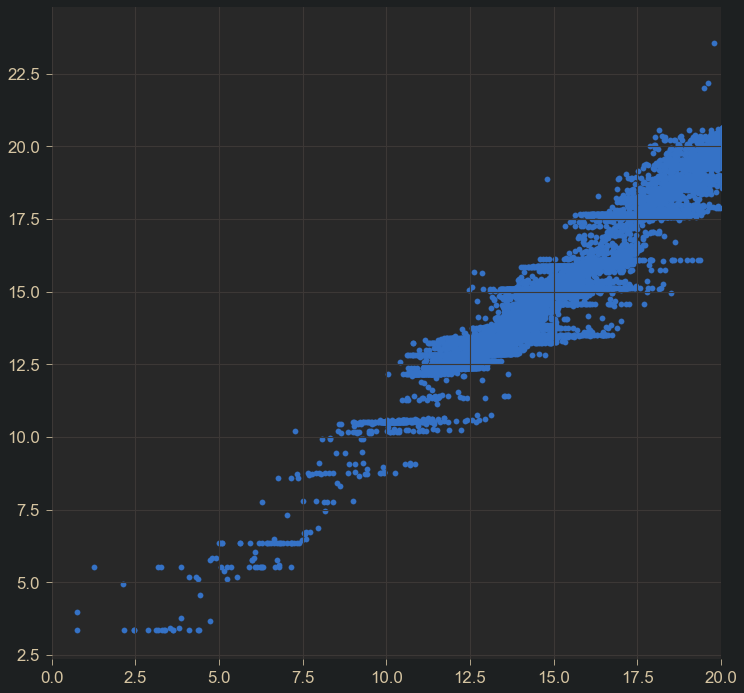

In [39]:
plt.scatter(eer_val,eer_val_pred)
plt.xlim(0,20)

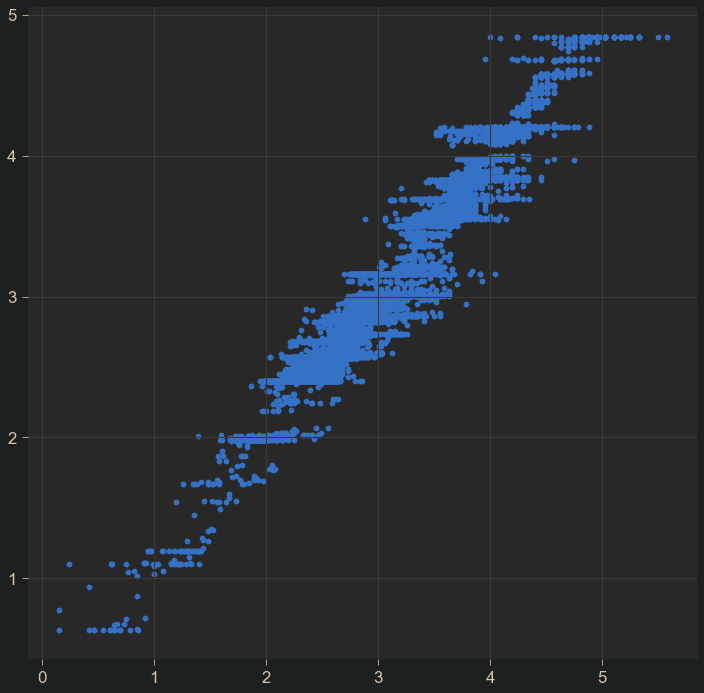

In [40]:
plt.scatter(COP_val,COP_val_pred)

%matplotlib notebook

(-2.0, 2.0)

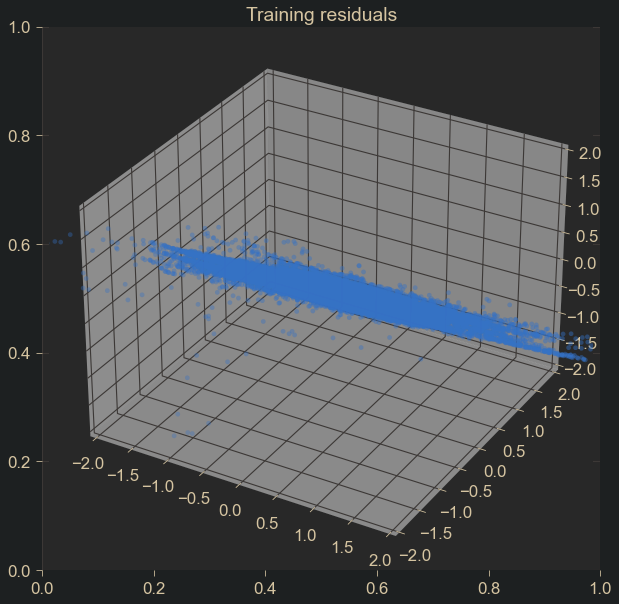

In [41]:

plt.figure(figsize=(10,10))
plt.title('Training residuals')
#creTE 3D AXRS
ax=plt.axes(projection='3d')

# plot data points

ax.scatter(eer_train_residuals,COP_train_residuals,kwton_train_residuals)
ax.set_xlim((-2,2))
ax.set_ylim((-2,2))
ax.set_zlim((-2,2))

(-2.0, 2.0)

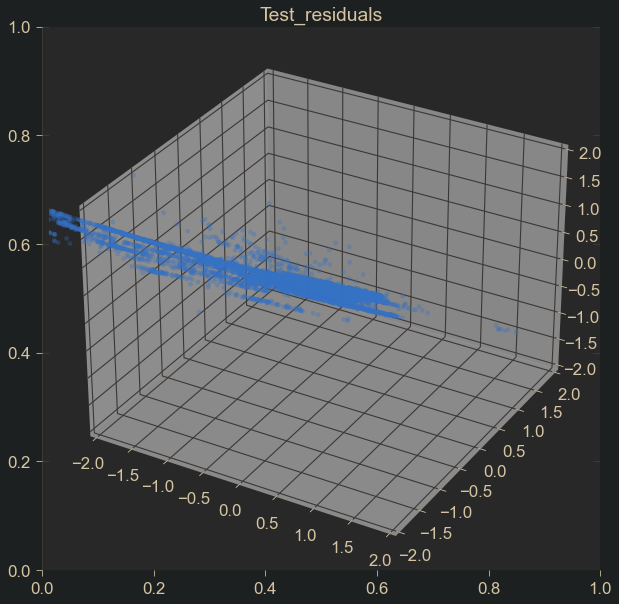

In [42]:
plt.figure(figsize=(10,10))
plt.title('Test_residuals')
#creTE 3D AXRS
ax=plt.axes(projection='3d')

# plot data points

ax.scatter(eer_test_residuals,COP_test_residuals,kwton_test_residuals)
ax.set_xlim((-2,2))
ax.set_ylim((-2,2))
ax.set_zlim((-2,2))

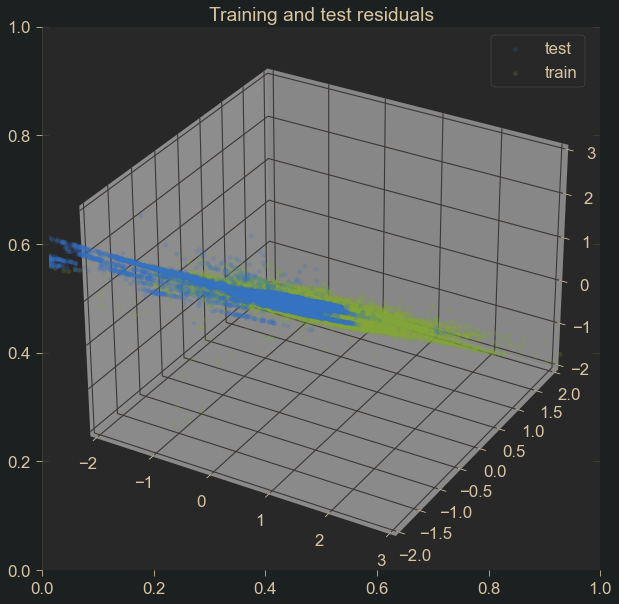

In [43]:
#matplotlib notebook

plt.figure(figsize=(10,10))
plt.title('Training and test residuals')
#creTE 3D AXRS
ax=plt.axes(projection='3d')

# plot data points

ax.scatter(eer_test_residuals,COP_test_residuals,kwton_test_residuals,alpha=.2,label='test')
ax.scatter(eer_train_residuals,COP_train_residuals,kwton_train_residuals,alpha=.2,label='train')
ax.set_xlim((-2,3))
ax.set_ylim((-2,2))
ax.set_zlim((-2,3))
plt.legend()

In [44]:

import numpy as np

residue=np.zeros((len(eer_test_residuals),3),dtype='float32')
norm_residue=np.zeros((len(eer_test_residuals),3),dtype='float32')
## normalize reisduals
norm_eer_res=(eer_test_residuals-np.quantile(eer_test_residuals,.05))/(np.quantile(eer_test_residuals,.95)-np.quantile(eer_test_residuals,.05))
norm_cop_res=(COP_test_residuals-np.quantile(COP_test_residuals,.05))/(np.quantile(COP_test_residuals,.95)-np.quantile(COP_test_residuals,.05))
norm_kwton_res=(kwton_test_residuals-np.quantile(kwton_test_residuals,.05))/(np.quantile(kwton_test_residuals,.95)-np.quantile(kwton_test_residuals,.05))

norm_residue[:,0]=norm_eer_res
norm_residue[:,1]=norm_cop_res
norm_residue[:,2]=norm_kwton_res




residue[:,0]=eer_test_residuals
residue[:,1]=COP_test_residuals
residue[:,2]=kwton_test_residuals


test_norm_residuals=pd.DataFrame(columns=['test_eer_res_norm','test_COP_res_norm','test_kwton_res_norm'],index=eer_test_residuals.index,data=norm_residue)


test_residuals=pd.DataFrame(columns=['test_eer_res','test_COP_res','test_kwton_res'],index=eer_test_residuals.index,data=residue)


In [45]:
train_residue=np.zeros((len(eer_train_residuals),3),dtype='float32')
train_norm_residue=np.zeros((len(eer_train_residuals),3),dtype='float32')
#Normalize
train_norm_eer_res=(eer_train_residuals-np.quantile(eer_train_residuals,.05))/(np.quantile(eer_train_residuals,.95)-np.quantile(eer_train_residuals,.05))
train_norm_cop_res=(COP_train_residuals-np.quantile(COP_train_residuals,.05))/(np.quantile(COP_train_residuals,.95)-np.quantile(COP_train_residuals,.05))
train_norm_kwton_res=(kwton_train_residuals-np.quantile(kwton_train_residuals,.05))/(np.quantile(kwton_train_residuals,.95)-np.quantile(kwton_train_residuals,.05))

## training normalized residue
train_norm_residue[:,0]=train_norm_eer_res
train_norm_residue[:,1]=train_norm_cop_res
train_norm_residue[:,2]=train_norm_kwton_res

## training residue
train_residue[:,0]=eer_train_residuals
train_residue[:,1]=COP_train_residuals
train_residue[:,2]=kwton_train_residuals

###add to data frame and sort by date
train_norm_residuals=pd.DataFrame(columns=['train_eer_res_norm','train_COP_res_norm','train_kwton_res_norm'],index=eer_train_residuals.index,data=train_norm_residue)
train_residuals=pd.DataFrame(columns=['train_eer_res','train_COP_res','train_kwton_res'],index=eer_train_residuals.index,data=train_residue)
train_residuals=train_residuals.sort_index()
train_norm_residuals=train_norm_residuals.sort_index()

In [46]:
train_residuals

,train_eer_res,train_COP_res,train_kwton_res
time,,,
2021-08-03 11:01:00,-0.075331,-0.082364,0.101534
2021-08-03 11:02:00,-0.005331,-0.067364,0.096534
2021-08-03 11:03:00,-0.070331,-0.067364,0.096534
2021-08-03 11:04:00,-0.035331,-0.067364,0.096534
2021-08-03 11:06:00,0.084669,-0.051003,0.086534
...,...,...,...
2022-02-08 04:33:00,0.202102,-0.037218,-0.012070
2022-02-08 04:34:00,0.215711,-0.041195,-0.012070
2022-02-08 04:35:00,0.227392,-0.037218,-0.012070


In [47]:
train_residuals

,train_eer_res,train_COP_res,train_kwton_res
time,,,
2021-08-03 11:01:00,-0.075331,-0.082364,0.101534
2021-08-03 11:02:00,-0.005331,-0.067364,0.096534
2021-08-03 11:03:00,-0.070331,-0.067364,0.096534
2021-08-03 11:04:00,-0.035331,-0.067364,0.096534
2021-08-03 11:06:00,0.084669,-0.051003,0.086534
...,...,...,...
2022-02-08 04:33:00,0.202102,-0.037218,-0.012070
2022-02-08 04:34:00,0.215711,-0.041195,-0.012070
2022-02-08 04:35:00,0.227392,-0.037218,-0.012070


In [48]:
train_norm_residuals

,train_eer_res_norm,train_COP_res_norm,train_kwton_res_norm
time,,,
2021-08-03 11:01:00,0.461893,0.302908,0.899329
2021-08-03 11:02:00,0.502232,0.342407,0.879651
2021-08-03 11:03:00,0.464774,0.342407,0.879651
2021-08-03 11:04:00,0.484944,0.342407,0.879651
2021-08-03 11:06:00,0.554098,0.385490,0.840293
...,...,...,...
2022-02-08 04:33:00,0.621772,0.421791,0.452208
2022-02-08 04:34:00,0.629614,0.411318,0.452208
2022-02-08 04:35:00,0.636346,0.421791,0.452208


In [49]:
test_norm_residuals

,test_eer_res_norm,test_COP_res_norm,test_kwton_res_norm
time,,,
2021-07-06 20:49:00,0.897289,0.865062,0.213380
2021-07-06 20:50:00,0.892668,0.865062,0.223587
2021-07-06 20:51:00,0.865426,0.813297,0.257024
2021-07-06 20:58:00,0.769662,0.709766,0.334471
2021-07-06 20:59:00,0.743661,0.696824,0.355294
...,...,...,...
2021-07-13 10:55:00,-0.131300,-0.051534,0.595770
2021-07-13 10:56:00,-0.118890,-0.020749,0.574946
2021-07-13 10:57:00,-0.137598,-0.090358,0.610330


In [57]:
#training
res_col=train_residuals.columns
minute=pd.concat([minute,train_residuals],axis=1)

res_col=train_norm_residuals.columns

minute=pd.concat([minute,train_norm_residuals],axis=1)

#Testing
res_col=test_residuals.columns
minute=pd.concat([minute,test_residuals],axis=1)

res_col=test_norm_residuals.columns
minute=pd.concat([minute,test_norm_residuals],axis=1)

minute.shape

(124582, 69)

Text(0.5, 0, 'kwton')

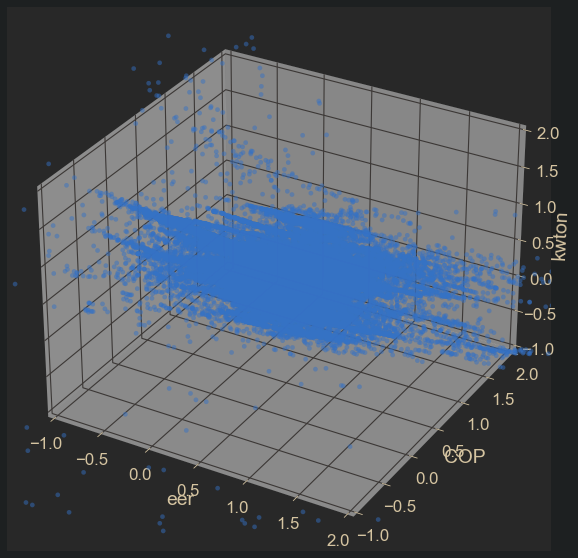

In [58]:
plt.figure(figsize=(10,10))
#create 3D AXRS
ax=plt.axes(projection='3d')

ax.scatter (train_norm_residuals.train_eer_res_norm,
            train_norm_residuals.train_COP_res_norm,
            train_norm_residuals.train_kwton_res_norm)
ax.set_xlim((-1,2))
ax.set_ylim((-1,2))
ax.set_zlim((-1,2))

ax.set_xlabel('eer')
ax.set_ylabel('COP')
ax.set_zlabel('kwton')

Text(0.5, 0, 'kwton')

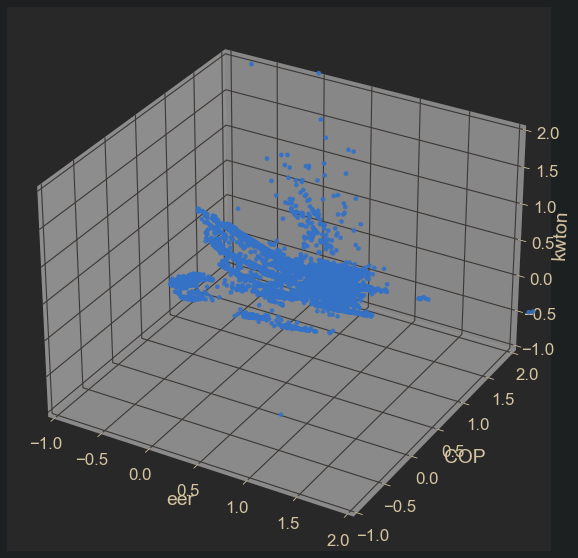

In [59]:
plt.figure(figsize=(10,10))
#create 3D AXRS
ax=plt.axes(projection='3d')

ax.scatter (test_norm_residuals.test_eer_res_norm,
            test_norm_residuals.test_COP_res_norm,
            test_norm_residuals.test_kwton_res_norm)
ax.set_xlim((-1,2))
ax.set_ylim((-1,2))
ax.set_zlim((-1,2))

ax.set_xlabel('eer')
ax.set_ylabel('COP')
ax.set_zlabel('kwton')

%matplotlib notebook

In [60]:
import warnings
warnings.filterwarnings('ignore')

## The sillouhette Score: mean sillouhette Coefficient
 - A= mean distance to the other points in the cluster
    - B= mean distance to points in the next closest cluster
    - the ideal sistuation is with a large A and a small B
    S=b=a/(max{a,b}  while S is between -1 and 1

 S~ 1 the points are near the center
 
 S~ 0 means the points are in the right cluster but close to the boundary of the classification
 
 S~ -1 the points are in the wrong cluster

In [61]:
#Choose a subsection of dates to cluster
start='2021-10-01'
end='2021-11-01'
train_residuals=train_residuals[start:end]
train_norm_residuals=train_norm_residuals[start:end]

In [62]:
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
# run k-means for different k values
#elbow method
k_values=[2,3,4,5,6,7,8,9,10]
agg_distances=[]
inertias=[]
scores=[]
for k in k_values:
    print(k)
    #kmeans
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(train_norm_residuals)
    inertias.append(kmeans.inertia_)
    #aggglomerative
    agg_clus=AgglomerativeClustering(n_clusters=k,linkage='complete',compute_distances=True)
    agg_clus.fit(train_norm_residuals)
    labels=agg_clus.labels_
    #Sillhouteete
    scores.append(silhouette_score(train_norm_residuals,labels))
    
                           


2
3
4
5
6
7
8
9
10


# find the best cluster sizes for the Training data set

Text(0.5, 0, 'Number of Clusters')

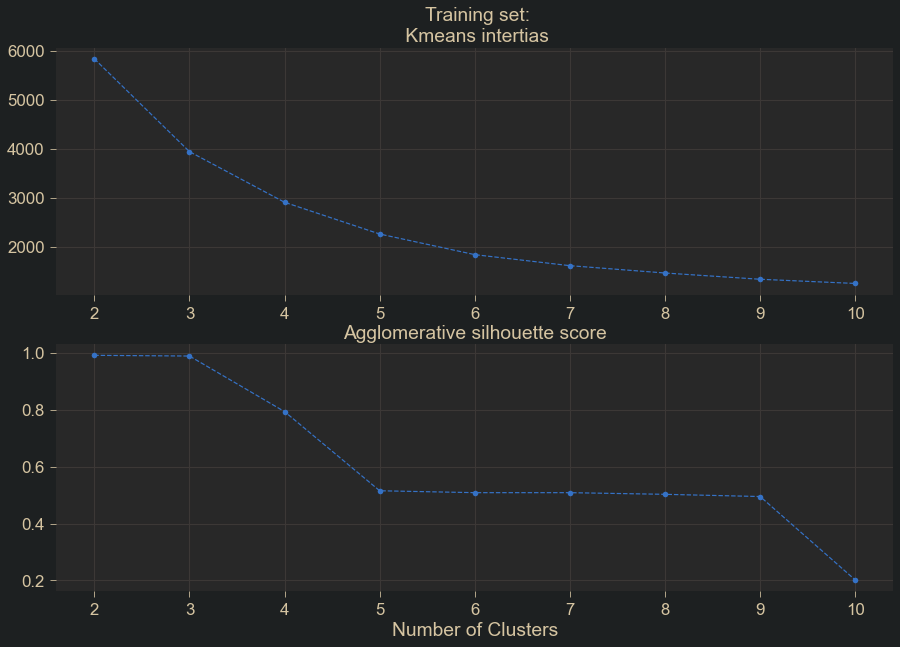

In [63]:
fig, axes= plt.subplots(nrows=2, figsize=(15, 10), sharex=False)

axes[0].plot(k_values,inertias,'o--')
axes[0].set_title(' Training set:\n Kmeans intertias')
axes[1].plot(k_values,scores,'o--')
axes[1].set_title('Agglomerative silhouette score')

plt.xlabel('Number of Clusters')
#plt.title('the elbow method',fontsize=15)

# The best Parameter for the Training set is 3 clusters
## training

In [64]:
# best cluster params
#dbclstr=DBSCAN(eps=.5,min_samples=50)
#dbclstr.fit(norm_residuals)
agg_clus=AgglomerativeClustering(n_clusters=3,linkage='complete',compute_distances=True)
kmeans=KMeans(n_clusters=3)

agg_clus.fit(train_norm_residuals)
kmeans.fit(train_norm_residuals)

train_norm_residuals['kmeans_clusters']=kmeans.labels_
train_norm_residuals['agglo_clusters']=agg_clus.labels_
#norm_residuals['db_clusters']=dbclstr.labels_


#minute['db_clusters']=norm_residuals['db_clusters']
minute['train_kmeans_clusters']=train_norm_residuals['kmeans_clusters']
minute['train_agglo_clusters']=train_norm_residuals['agglo_clusters']

In [65]:
train_norm_residuals.agglo_clusters.value_counts()

0    15902
2        1
1        1
Name: agglo_clusters, dtype: int64

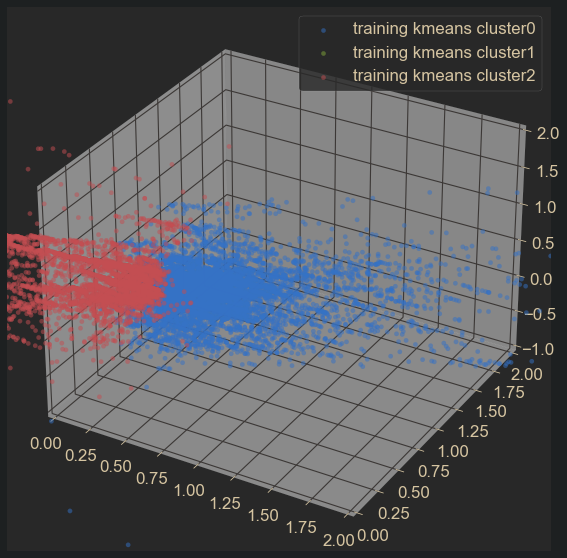

In [66]:
plt.figure(figsize=(10,10))
#create 3D AXRS
ax=plt.axes(projection='3d')
k=3
for i in range(k):
    ax.scatter (train_norm_residuals.train_eer_res_norm[train_norm_residuals.kmeans_clusters==i],
                train_norm_residuals.train_COP_res_norm[train_norm_residuals.kmeans_clusters==i],
                train_norm_residuals.train_kwton_res_norm[train_norm_residuals.kmeans_clusters==i],alpha=.5,label='training kmeans cluster'+str(i))
ax.set_xlim((0,2))
ax.set_ylim((0,2))
ax.set_zlim((-1,2))
plt.legend()

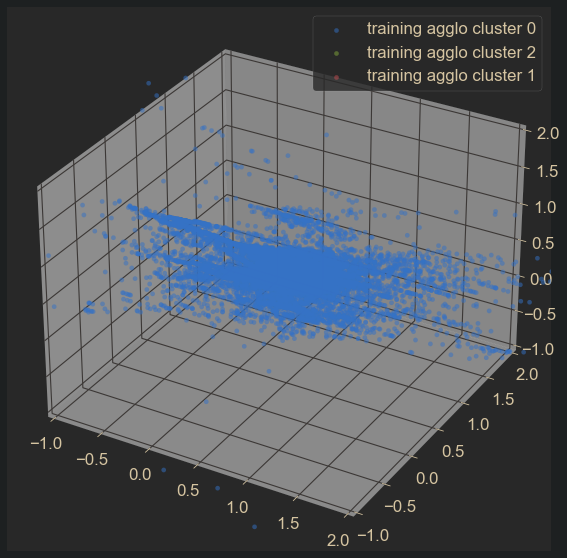

In [67]:

plt.figure(figsize=(10,10))
#create 3D AXRS
ax=plt.axes(projection='3d')
k=train_norm_residuals.agglo_clusters.unique()
for i in k:
    ax.scatter (train_norm_residuals.train_eer_res_norm[train_norm_residuals.agglo_clusters==i],
                train_norm_residuals.train_COP_res_norm[train_norm_residuals.agglo_clusters==i],
                train_norm_residuals.train_kwton_res_norm[train_norm_residuals.agglo_clusters==i],alpha=.5,label='training agglo cluster '+str(i))
ax.set_xlim((-1,2))
ax.set_ylim((-1,2))
ax.set_zlim((-1,2))
plt.legend()

In [68]:
k_values=[2,3,4,5,6,7,8,9,10]
agg_distances=[]
inertias=[]
scores=[]
for k in k_values:
    #kmeans
    print(k)
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(test_norm_residuals)
    
    inertias.append(kmeans.inertia_)
    #aggglomerative
    agg_clus=AgglomerativeClustering(n_clusters=k,compute_distances=True)
    agg_clus.fit(test_norm_residuals)
    labels=agg_clus.labels_
    
    #Sillhouteete
    scores.append(silhouette_score(test_norm_residuals,labels))

2
3
4
5
6
7
8
9
10


In [69]:
###repeat the cluster\ search process for the testing Set

Text(0.5, 1.0, 'Agglomerative silhouette score method')

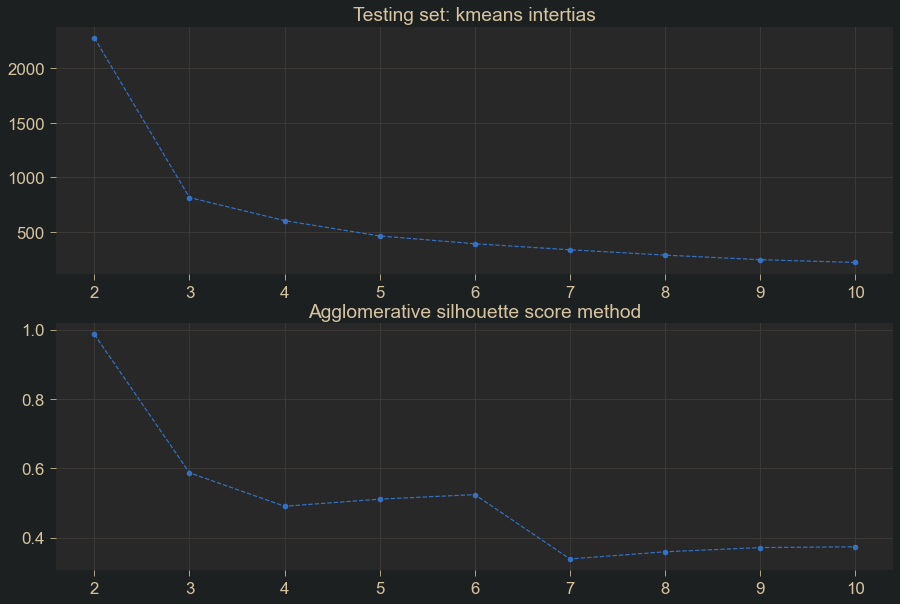

In [70]:
fig, axes= plt.subplots(nrows=2, figsize=(15, 10), sharex=False)

axes[0].plot(k_values,inertias,'o--')
axes[0].set_title('Testing set: kmeans intertias')
axes[1].plot(k_values,scores,'o--')
axes[1].set_title('Agglomerative silhouette score method')

#plt.xlabel('number of clusters')
#plt.ylabel('inertia')
#plt.title('the elbow method',fontsize=15)

# The best parameters for the Testing set is 4-7
## for max diversity of clusters 5 was chosen
### testing set

In [71]:
# best cluster params
#dbclstr=DBSCAN(eps=.5,min_samples=50)
#dbclstr.fit(norm_residuals)
agg_clus=AgglomerativeClustering(n_clusters=5,compute_distances=True)
kmeans=KMeans(n_clusters=5)

agg_clus.fit(test_norm_residuals)
kmeans.fit(test_norm_residuals)

test_norm_residuals['test_kmeans_clusters']=kmeans.labels_
test_norm_residuals['test_agglo_clusters']=agg_clus.labels_
#norm_residuals['db_clusters']=dbclstr.labels_


#minute['db_clusters']=norm_residuals['db_clusters']
minute['test_kmeans_clusters']=test_norm_residuals['test_kmeans_clusters']
minute['test_agglo_clusters']=test_norm_residuals['test_agglo_clusters']

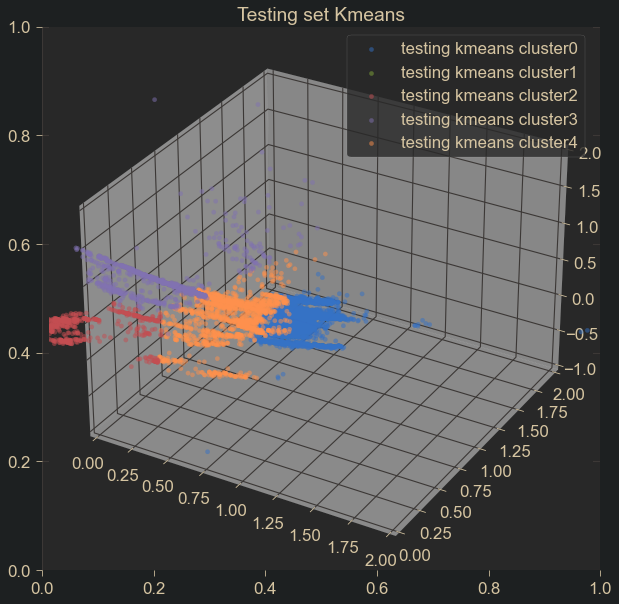

In [72]:
plt.figure(figsize=(10,10))
plt.title('Testing set Kmeans')
#create 3D AXRS
ax=plt.axes(projection='3d')
k=5
for i in range(k):
    ax.scatter (test_norm_residuals.test_eer_res_norm[test_norm_residuals.test_kmeans_clusters==i],
                test_norm_residuals.test_COP_res_norm[test_norm_residuals.test_kmeans_clusters==i],
                test_norm_residuals.test_kwton_res_norm[test_norm_residuals.test_kmeans_clusters==i],alpha=.5,label='testing kmeans cluster'+str(i))
ax.set_xlim((0,2))
ax.set_ylim((0,2))
ax.set_zlim((-1,2))
plt.legend()

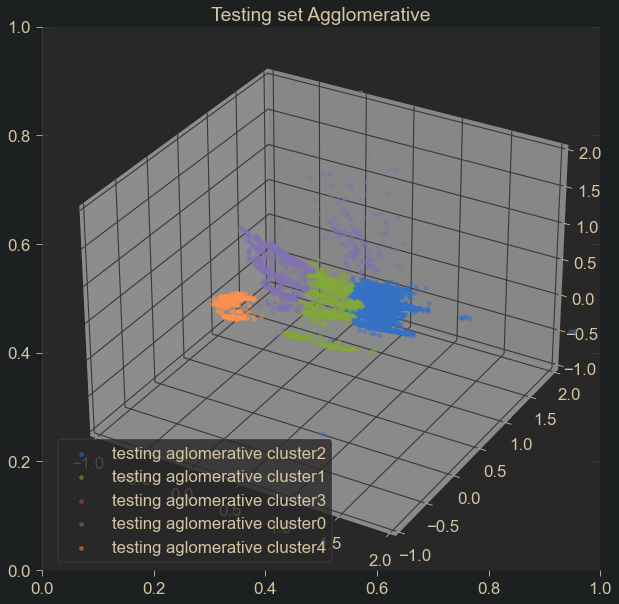

In [73]:
plt.figure(figsize=(10,10))
plt.title('Testing set Agglomerative')
#create 3D AXRS
ax=plt.axes(projection='3d')
k=test_norm_residuals.test_agglo_clusters.unique()
for i in k:
    ax.scatter (test_norm_residuals.test_eer_res_norm[test_norm_residuals.test_agglo_clusters==i],
                test_norm_residuals.test_COP_res_norm[test_norm_residuals.test_agglo_clusters==i],
                test_norm_residuals.test_kwton_res_norm[test_norm_residuals.test_agglo_clusters==i],alpha=.5,label='testing aglomerative cluster'+str(i))
ax.set_xlim((-1,2))
ax.set_ylim((-1,2))
ax.set_zlim((-1,2))
plt.legend()

In [74]:
minute.head()

,name,cfm,COP,Delta_Enthalpy,kw,kwton,OAtemp,humidity1,temp1,eer,...,test_eer_res,test_COP_res,test_kwton_res,test_eer_res_norm,test_COP_res_norm,test_kwton_res_norm,train_kmeans_clusters,train_agglo_clusters,test_kmeans_clusters,test_agglo_clusters
time,,,,,,,,,,,,,,,,,,,,,
2021-06-26 21:56:00,458.0,19.320,0.02,0.73,1.98,198.00,74.12,55.20,73.9,0.060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:57:00,458.0,18.975,0.02,0.75,1.98,198.00,73.94,59.20,73.8,0.050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:58:00,458.0,19.320,0.02,0.75,1.98,198.00,73.94,59.20,73.8,0.060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:59:00,458.0,19.320,0.02,0.73,1.98,198.00,73.94,59.10,73.8,0.060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 22:00:00,458.0,18.975,0.09,7.28,1.98,41.25,73.94,89.55,74.4,0.555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:

minute['test_kmeans_clusters']=test_norm_residuals['test_kmeans_clusters']
minute['test_agglo_clusters']=test_norm_residuals['test_agglo_clusters']

In [76]:
minute.head()

,name,cfm,COP,Delta_Enthalpy,kw,kwton,OAtemp,humidity1,temp1,eer,...,test_eer_res,test_COP_res,test_kwton_res,test_eer_res_norm,test_COP_res_norm,test_kwton_res_norm,train_kmeans_clusters,train_agglo_clusters,test_kmeans_clusters,test_agglo_clusters
time,,,,,,,,,,,,,,,,,,,,,
2021-06-26 21:56:00,458.0,19.320,0.02,0.73,1.98,198.00,74.12,55.20,73.9,0.060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:57:00,458.0,18.975,0.02,0.75,1.98,198.00,73.94,59.20,73.8,0.050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:58:00,458.0,19.320,0.02,0.75,1.98,198.00,73.94,59.20,73.8,0.060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:59:00,458.0,19.320,0.02,0.73,1.98,198.00,73.94,59.10,73.8,0.060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 22:00:00,458.0,18.975,0.09,7.28,1.98,41.25,73.94,89.55,74.4,0.555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


10- 50 core instances(pre/post)
after creating the distance matrix use the smallest 5-50 distances.

In [77]:
minute.to_csv('minute_with_clusters.csv')
#minute=pd.read_csv('minute_with_clusters.csv')

In [78]:
k

array([2, 1, 3, 0, 4], dtype=int64)

In [79]:
start='2021-06-24'
end='2021-06-26'

In [80]:
import seaborn as sns
sns.set_style('whitegrid')
colors=['tab:blue','tab:orange','tab:green',
        'tab:red','tab:purple','tab:brown',
        'tab:pink','tab:gray','tab:olive','tab:cyan']

In [81]:
variables=[
    #'cfm',
    'COP',
    #'Delta_Enthalpy',
    #'kw',
    'kwton',
    #'OAtemp',
    #'humidity1',
    #'temp1',
    'eer']
cluster=list(minute.test_agglo_clusters.unique())
clusters=[k for k in cluster if not np.isnan(k)]
#variables,clusters

In [82]:
variables,clusters

(['COP', 'kwton', 'eer'], [2.0, 1.0, 3.0, 0.0, 4.0])

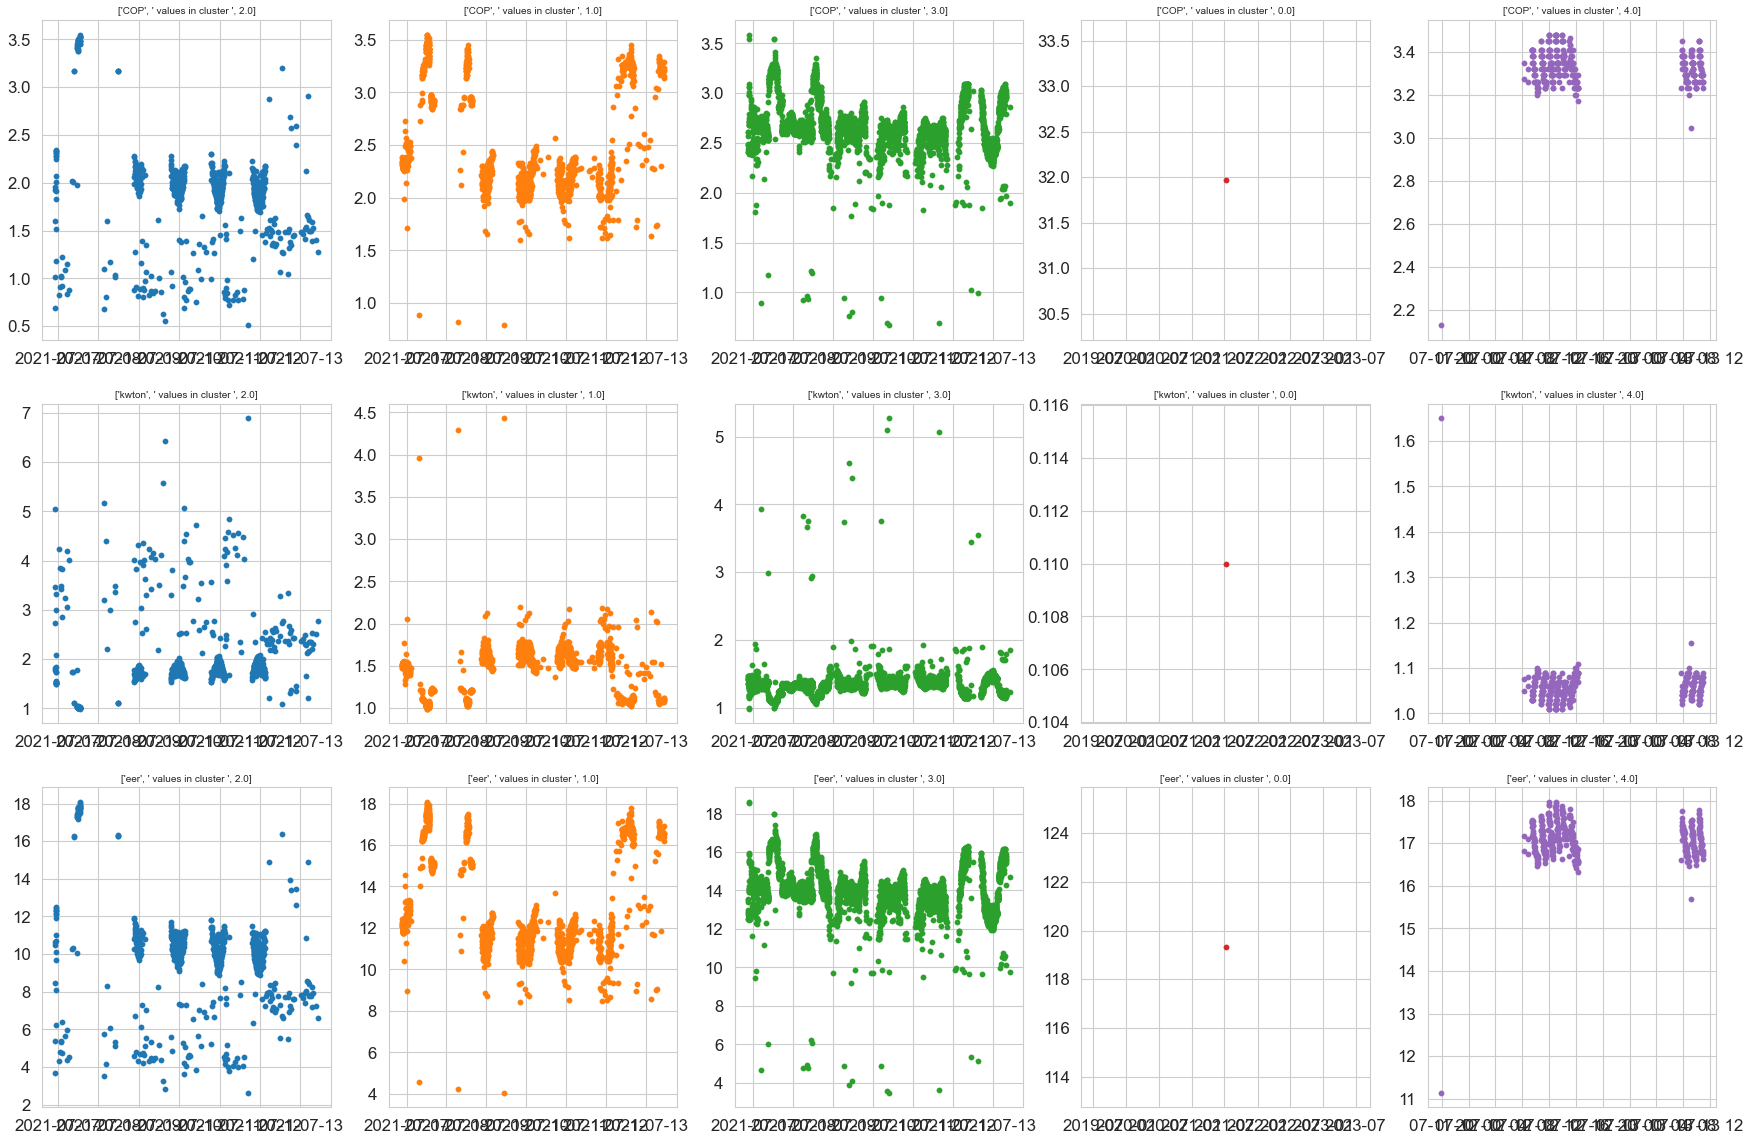

In [83]:
fig, axes = plt.subplots(nrows=len(variables),ncols=len(clusters),figsize=(30,20))
for i,variable in enumerate(variables):
    for j,cluster in enumerate(clusters):
        
        axes[i,j].scatter(minute.index[minute.test_agglo_clusters==j],minute[variable][minute.test_agglo_clusters==j],color=colors[j])
        axes[i,j].set_title([variable ,' values in cluster ',cluster],fontsize=10)
plt.savefig('agglo_4_clusters_clusr_targets.pdf')

In [84]:
clusters=sorted(minute.test_kmeans_clusters.unique())[1:]


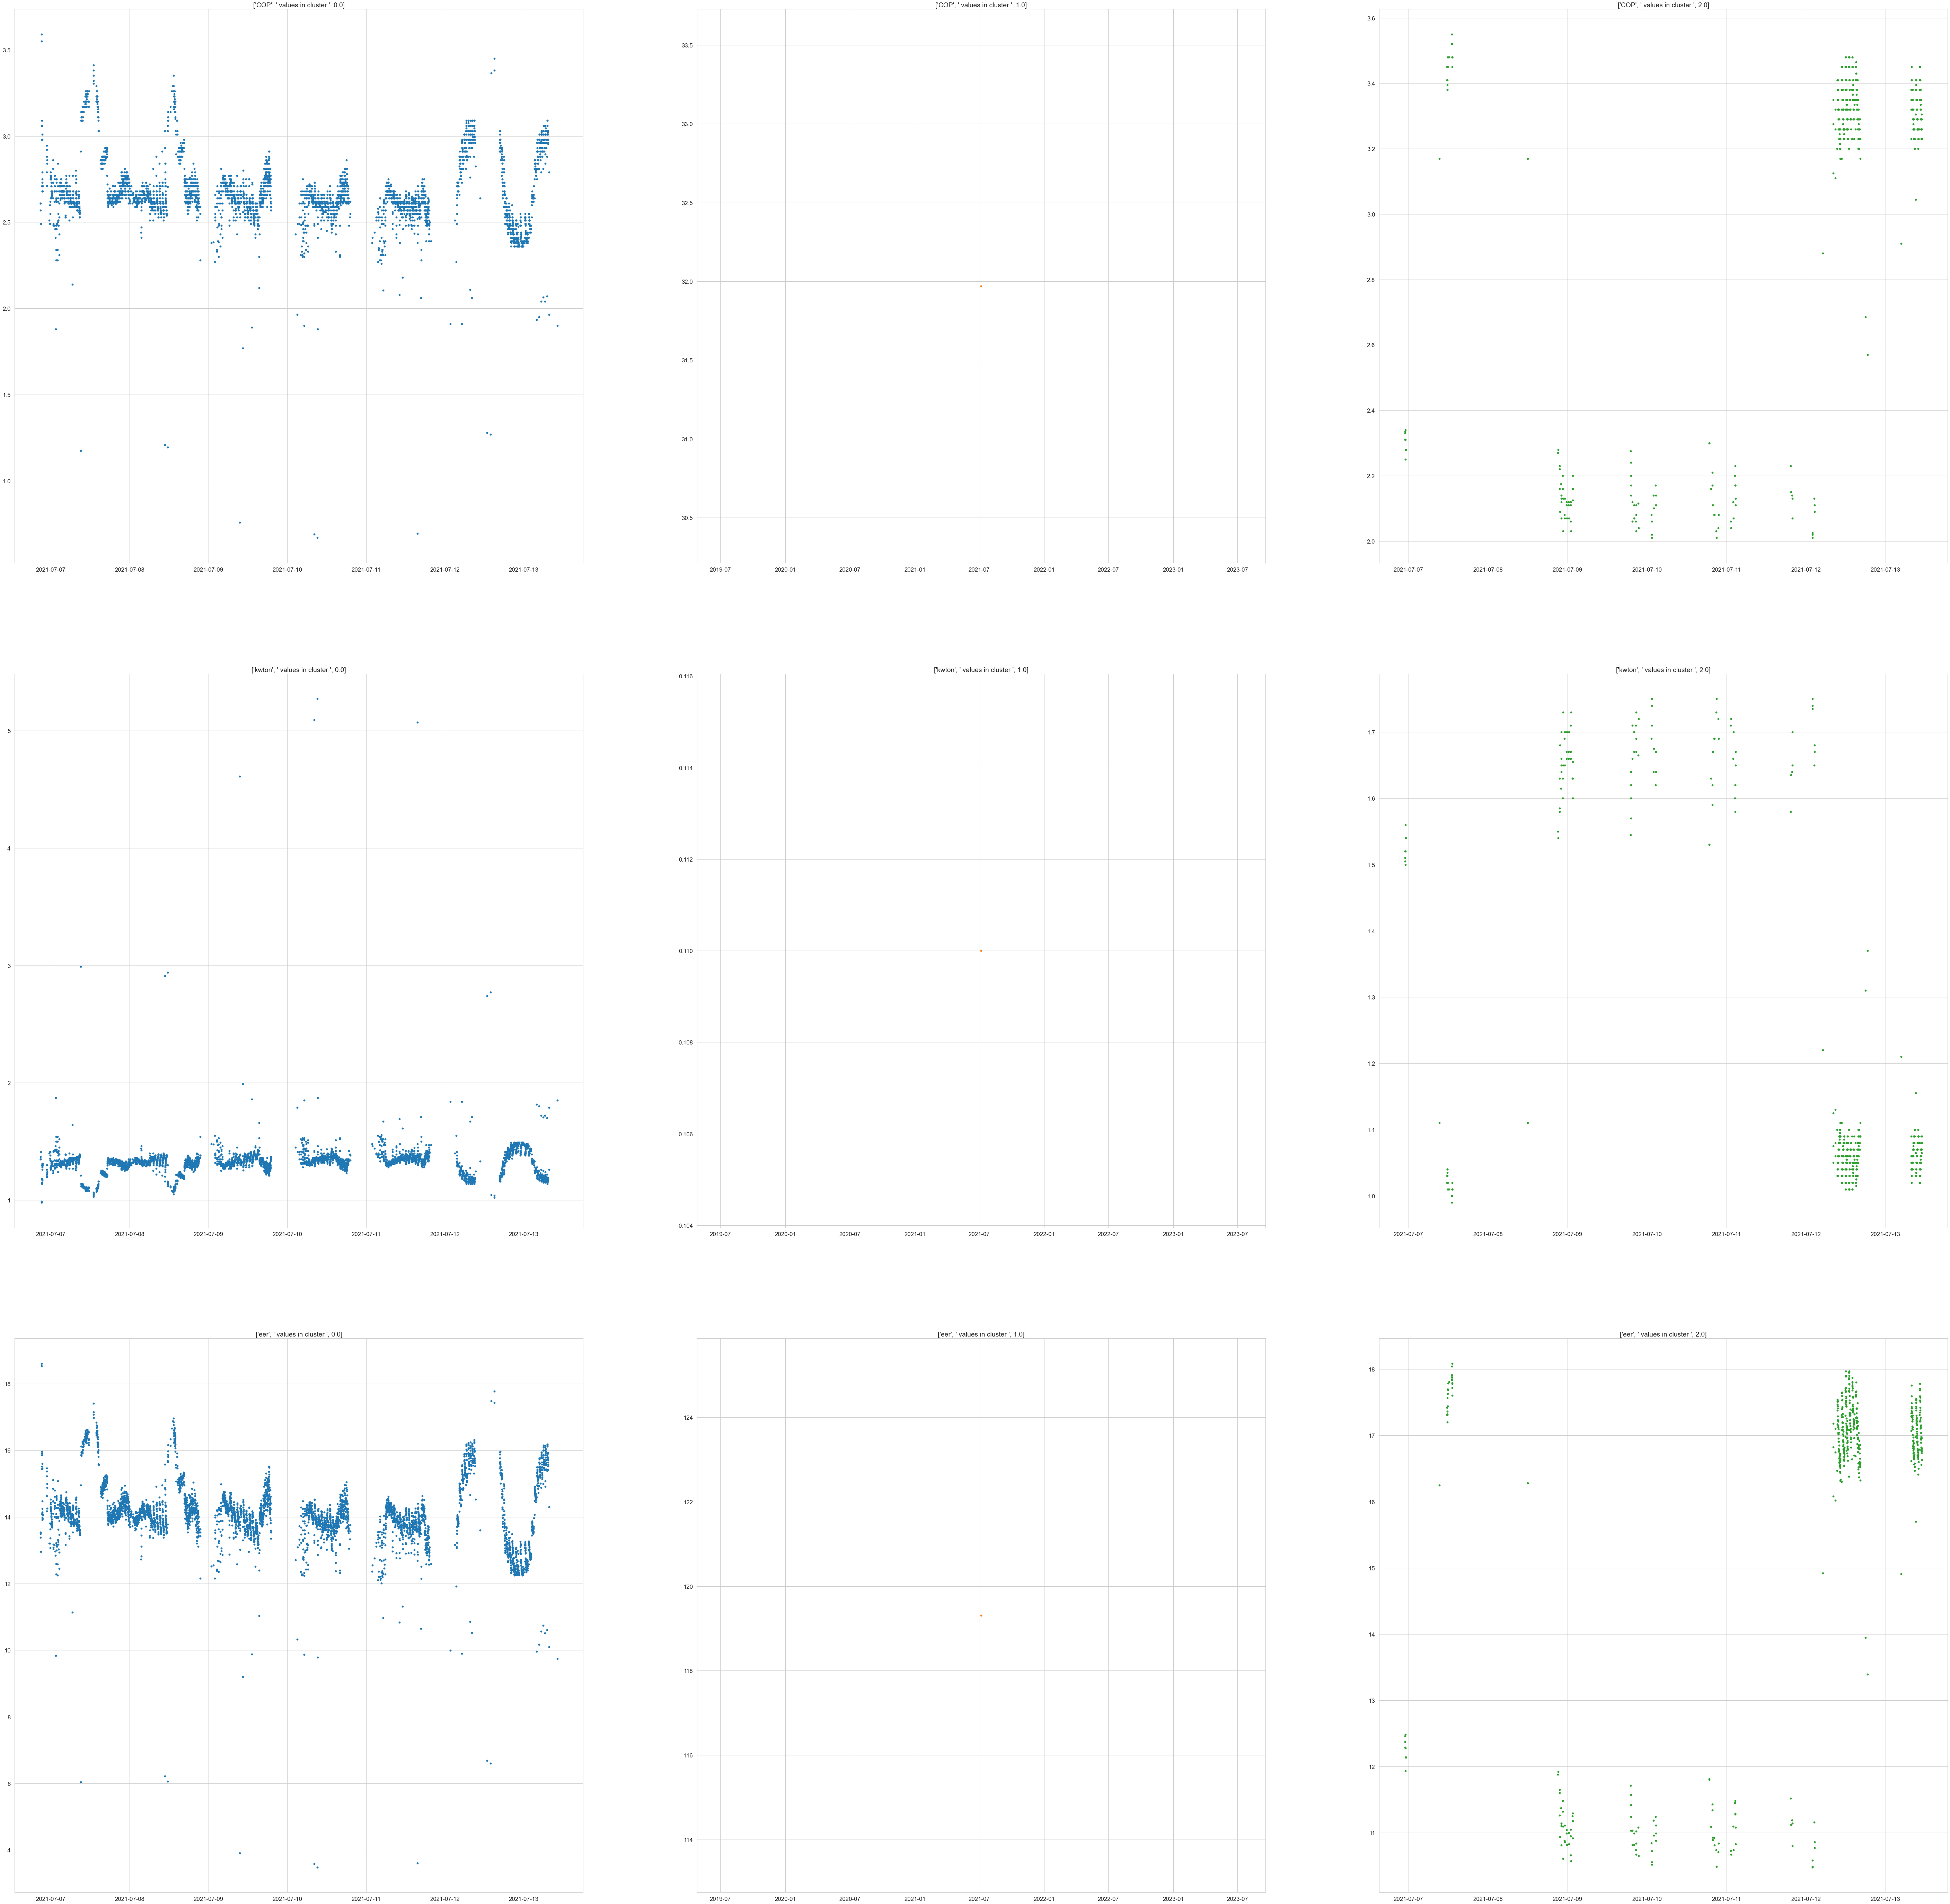

In [85]:
clusters=sorted(minute.train_kmeans_clusters.unique())[1:]
fig, axes = plt.subplots(nrows=len(variables),ncols=len(clusters),figsize=(100,100))
for i,variable in enumerate(variables):
    for j,cluster in enumerate(clusters):
        
        axes[i,j].scatter(minute.index[minute.test_kmeans_clusters==j],minute[variable][minute.test_kmeans_clusters==j],color=colors[j])
        axes[i,j].set_title([variable ,' values in cluster ',cluster])
plt.show()